In [1]:
import os
import os.path as osp

import time
import os, mmap
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import add_self_loops
from sklearn.manifold import TSNE
import numpy as np
from torch_geometric.datasets import Planetoid
import nvsmi
import threading
import psutil

# Test system evaluation index

In [3]:
import nvsmi
import threading
import psutil
import os
import os.path as osp


disk_io_counter = psutil.disk_io_counters()
disk_total = disk_io_counter[2] + disk_io_counter[3]  # read_bytes + write_bytes
p = psutil.Process(os.getpid())
group_mem_rss = []
group_disk_usage = []
group_iowait = []
t_status = True

def get_gpu_info():
    while True:
        if not t_status:
            break
        group_mem_rss.append(psutil.Process(os.getpid()).memory_info().rss)
        io_counters = p.io_counters()
        disk_usage = io_counters[2] + io_counters[3]
        group_disk_usage.append(disk_usage)  # read_bytes + write_bytes
        try:
            a = psutil.cpu_times_percent().iowait
        except:
            a = 0
        group_iowait.append(a)
#         print(f"{disk_usage / 1024 / 1024} Mb/s")
#         time.sleep(0.09)

# Loading data and sampling

In [4]:
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import Reddit
import torch
from torch_geometric.loader import NeighborSampler
# from NS import NeighborSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from SAGEConv import SAGEConv
from tqdm import tqdm
import torch.optim as optim
import numpy as np
import time

# from torch.utils.data import DataLoader

dataset = Planetoid(root='./cora/', name='Cora')
# dataset = Planetoid(root='./citeseer',name='Citeseer')
# dataset = Planetoid(root='./pubmed/',name='Pubmed')
# dataset = Reddit(root='./reddit/')
print(dataset)

start_time = time.time()
t = threading.Thread(target=get_gpu_info)
t.start()
train_loader = NeighborSampler(dataset[0].edge_index, node_idx=dataset[0].train_mask,
                               sizes=[10, 10], batch_size=128, shuffle=True,
                               num_workers=8,pin_memory=True)
t_status = False
t.join()

# # Reddit
# train_loader = NeighborSampler(dataset[0].edge_index, node_idx=dataset[0].train_mask,
#                                sizes=[25, 10], batch_size=1024, shuffle=True,
#                                num_workers=8,pin_memory=True)

end_time = time.time()
init_sample_time = end_time - start_time
print('NeighborSampler time:{}'.format(end_time - start_time))
print(f'内存使用：{np.mean(group_mem_rss) / 1024 / 1024 / 1024:.4f} GB')
print(f'磁盘IO使用：{np.mean(group_disk_usage) / 1024 / 1024 / 1024:.4f} GB/s')
print(f'磁盘IO使用率：{np.mean(group_disk_usage) * 100 / disk_total:.4f}%')
print(f'cpu iowait：{np.mean(group_iowait)}')


subgraph_loader = NeighborSampler(dataset[0].edge_index, node_idx=None, sizes=[-1],
                                  batch_size=1024, shuffle=False,
                                  num_workers=8)

Cora()
NeighborSampler time:0.44434523582458496
内存使用：4.5272 GB
磁盘IO使用：11.3440 GB/s
磁盘IO使用率：2.6147%
cpu iowait：0.0


# Traning

In [5]:
gpu_data = list(nvsmi.get_gpus())[0]
start_gpu_util = gpu_data.gpu_util
start_gpu_mem_use = gpu_data.mem_used
total_gpu_mem = gpu_data.mem_total
disk_io_counter = psutil.disk_io_counters()
disk_total = disk_io_counter[2] + disk_io_counter[3]  # read_bytes + write_bytes
p = psutil.Process(os.getpid())
group_mem_rss = []
group_gpu_util = []
group_gpu_mem_use = []
group_disk_usage = []
group_iowait = []
t_status = True

def get_gpu_info():
    gpu_data = list(nvsmi.get_gpus())[0]
    while True:
        if not t_status:
            break
        group_gpu_util.append(gpu_data.gpu_util)
        group_gpu_mem_use.append(gpu_data.mem_used)
        group_mem_rss.append(psutil.Process(os.getpid()).memory_info().rss)
        io_counters = p.io_counters()
        disk_usage = io_counters[2] + io_counters[3]
        group_disk_usage.append(disk_usage)  # read_bytes + write_bytes
        try:
            a = psutil.cpu_times_percent().iowait
        except:
            a = 0
        group_iowait.append(a)


class SAGENet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SAGENet, self).__init__()

        self.num_layers = 2

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x, adjs):
        # `train_loader` computes the k-hop neighborhood of a batch of nodes,
        # and returns, for each layer, a bipartite graph object, holding the
        # bipartite edges `edge_index`, the index `e_id` of the original edges,
        # and the size/shape `size` of the bipartite graph.
        # Target nodes are also included in the source nodes so that one can
        # easily apply skip-connections or add self-loops.

        lin_times = 0
        mes_times = 0
        aggr_times = 0
        up_times = 0

        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x, linear_time, message_time, aggregate_time, update_time = self.convs[i]((x, x_target), edge_index)
            lin_times += linear_time
            mes_times += message_time
            aggr_times += aggregate_time
            up_times += update_time
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x.log_softmax(dim=-1), lin_times, mes_times, aggr_times, up_times

    def inference(self, x_all):
        pbar = tqdm(total=x_all.size(0) * self.num_layers)
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x, linear_time, message_time, aggregate_time, update_time = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = F.relu(x)
                xs.append(x.cpu())

                pbar.update(batch_size)

            x_all = torch.cat(xs, dim=0)

        pbar.close()

        return x_all


# cora
model = SAGENet(dataset.num_features, 16, dataset.num_classes)

# Reddit
# model = SAGENet(dataset.num_features, 256, dataset.num_classes)
print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.cuda()
model.to(device)
data = dataset[0].to(device)
print(data)

x = data.x.to(device)
y = data.y.squeeze().to(device)

criterion = nn.NLLLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


def train(epoch):
    model.train()

    pbar = tqdm(total=int(data.train_mask.sum()))
    pbar.set_description(f'Epoch {epoch:02d}')

    total_lin_time = 0
    total_mes_time = 0
    total_aggr_time = 0
    total_up_time = 0

    total_sample_time = 0

    total_loss = total_correct = 0
    start_time = time.time()
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        end_time = time.time()
        total_sample_time += (end_time - start_time)

        adjs = [adj.to(device) for adj in adjs]

        optimizer.zero_grad()
        out, lin_time, mes_time, aggr_time, up_time = model(x[n_id], adjs)

        total_lin_time += lin_time
        total_mes_time += mes_time
        total_aggr_time += aggr_time
        total_up_time += up_time

        loss = F.nll_loss(out, y[n_id[:batch_size]])
        loss.backward()
        optimizer.step()

        total_loss += float(loss)
        total_correct += int(out.argmax(dim=-1).eq(y[n_id[:batch_size]]).sum())
        pbar.update(batch_size)
        start_time = time.time()

    pbar.close()

    loss = total_loss / len(train_loader)
    approx_acc = total_correct / int(data.train_mask.sum())

    return loss, approx_acc, total_lin_time, total_mes_time, total_aggr_time, total_up_time, total_sample_time


@torch.no_grad()
def test():
    model.eval()

    out = model.inference(x)

    y_true = y.cpu().unsqueeze(-1)
    y_pred = out.argmax(dim=-1, keepdim=True)

    results = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        results += [int(y_pred[mask].eq(y_true[mask]).sum()) / int(mask.sum())]

    return results

# def test():  # Inference should be performed on the full graph.
#     model.eval()

#     out = model.inference(data.x)
#     y_pred = out.argmax(dim=-1)

#     accs = []
#     for mask in [data.train_mask, data.val_mask, data.test_mask]:
#         correct = y_pred[mask].eq(data.y[mask]).sum().item()
#         accs.append(correct / mask.sum().item())
    return accs


lin_times = []
mes_times = []
aggr_times = []
up_times = []
sample_times = []

start_time = time.time()
for epoch in range(1, 11):
    if epoch == 1:
        t = threading.Thread(target=get_gpu_info)
        t.start()
    loss, acc, lin_time, mes_time, aggr_time, up_time, sample_time = train(epoch)

    lin_times.append(lin_time)
    mes_times.append(mes_time)
    aggr_times.append(aggr_time)
    up_times.append(up_time)
    sample_times.append(sample_time)

    print(f'Epoch {epoch:02d}, Loss: {loss:.4f}, Approx. Train: {acc:.4f}')

    train_acc, val_acc, test_acc = test()
    print(f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')
t_status = False
t.join()
end_time = time.time()
print("Average linear time:", 1000 * np.mean(lin_times), 'ms')
print("Average message time:", 1000 * np.mean(mes_times), 'ms')
print("Average aggregate time:", 1000 * np.mean(aggr_times), 'ms')
print("Average update time:", 1000 * np.mean(up_times), 'ms')
print("Average sample time:", (1000 * np.mean(sample_times) + init_sample_time), 'ms')
print("========================================================")
print(f"GPU 显存占用: {np.mean(group_gpu_mem_use)}Mb")
print(f"GPU 显存占用率: {np.mean(group_gpu_mem_use) * 100 / total_gpu_mem}%")
print(f"GPU 平均使用率: {np.mean(group_gpu_util) - start_gpu_util}%")
tmp_ = sum(np.where(np.array(group_gpu_util) - start_gpu_util > 1, True, False))
print(f"GPU 空闲率: {(len(group_gpu_util) - tmp_) * 100 / len(group_gpu_util)}%")
print(f'内存使用：{np.mean(group_mem_rss) / 1024 / 1024 / 1024:.4f} GB')
print(f'磁盘IO使用：{np.mean(group_disk_usage) / 1024 / 1024 / 1024:.4f} GB/s')
print(f'磁盘IO使用率：{np.mean(group_disk_usage) * 100 / disk_total:.4f}%')
print(f'cpu iowait：{np.mean(group_iowait)}')
print("Total training and evaluation time:", end_time - start_time)

SAGENet(
  (convs): ModuleList(
    (0): SAGEConv(1433, 16)
    (1): SAGEConv(16, 7)
  )
)
cuda
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])



Epoch 01: 100%|██████████████████████████████████████████████████████████████████████| 140/140 [00:13<00:00, 10.41it/s]


Epoch 01, Loss: 1.9128, Approx. Train: 0.1714



Evaluating: 100%|█████████████████████████████████████████████████████████████████| 5416/5416 [00:12<00:00, 424.34it/s]


Train: 0.5214, Val: 0.4020, Test: 0.4270



Epoch 02: 100%|██████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 16.51it/s]


Epoch 02, Loss: 1.7054, Approx. Train: 0.4643



Evaluating: 100%|█████████████████████████████████████████████████████████████████| 5416/5416 [00:13<00:00, 409.14it/s]


Train: 0.9143, Val: 0.6000, Test: 0.5960



Epoch 03: 100%|██████████████████████████████████████████████████████████████████████| 140/140 [00:09<00:00, 15.45it/s]


Epoch 03, Loss: 1.3141, Approx. Train: 0.7357



Evaluating: 100%|█████████████████████████████████████████████████████████████████| 5416/5416 [00:13<00:00, 405.24it/s]


Train: 0.9643, Val: 0.6300, Test: 0.6580



Epoch 04: 100%|██████████████████████████████████████████████████████████████████████| 140/140 [00:09<00:00, 14.58it/s]


Epoch 04, Loss: 1.0634, Approx. Train: 0.8643



Evaluating: 100%|█████████████████████████████████████████████████████████████████| 5416/5416 [00:11<00:00, 457.41it/s]


Train: 0.9714, Val: 0.6580, Test: 0.6810



Epoch 05: 100%|██████████████████████████████████████████████████████████████████████| 140/140 [00:09<00:00, 15.05it/s]


Epoch 05, Loss: 0.9102, Approx. Train: 0.8500



Evaluating: 100%|█████████████████████████████████████████████████████████████████| 5416/5416 [00:13<00:00, 399.43it/s]


Train: 0.9714, Val: 0.6860, Test: 0.7110



Epoch 06: 100%|██████████████████████████████████████████████████████████████████████| 140/140 [00:09<00:00, 15.31it/s]


Epoch 06, Loss: 0.7168, Approx. Train: 0.9071



Evaluating: 100%|█████████████████████████████████████████████████████████████████| 5416/5416 [00:13<00:00, 405.45it/s]


Train: 0.9857, Val: 0.6900, Test: 0.7160



Epoch 07: 100%|██████████████████████████████████████████████████████████████████████| 140/140 [00:09<00:00, 14.04it/s]


Epoch 07, Loss: 0.4234, Approx. Train: 0.8857



Evaluating: 100%|█████████████████████████████████████████████████████████████████| 5416/5416 [00:12<00:00, 447.25it/s]


Train: 0.9857, Val: 0.6840, Test: 0.7060



Epoch 08: 100%|██████████████████████████████████████████████████████████████████████| 140/140 [00:09<00:00, 15.25it/s]


Epoch 08, Loss: 0.3568, Approx. Train: 0.8929



Evaluating: 100%|█████████████████████████████████████████████████████████████████| 5416/5416 [00:12<00:00, 418.11it/s]


Train: 0.9929, Val: 0.6880, Test: 0.7140



Epoch 09: 100%|██████████████████████████████████████████████████████████████████████| 140/140 [00:09<00:00, 15.44it/s]


Epoch 09, Loss: 0.2688, Approx. Train: 0.9643



Evaluating: 100%|█████████████████████████████████████████████████████████████████| 5416/5416 [00:13<00:00, 414.28it/s]


Train: 0.9929, Val: 0.6900, Test: 0.7110



Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 15.87it/s]


Epoch 10, Loss: 0.2162, Approx. Train: 0.9500



Evaluating: 100%|█████████████████████████████████████████████████████████████████| 5416/5416 [00:12<00:00, 437.60it/s]


Train: 0.9929, Val: 0.7000, Test: 0.7210
Average linear time: 216.61405563354492 ms
Average message time: 0.0 ms
Average aggregate time: 787.5793218612671 ms
Average update time: 130.07795810699463 ms
Average sample time: 3568.6318204402924 ms
GPU 显存占用: 973.0Mb
GPU 显存占用率: 11.87744140625%
GPU 平均使用率: 0.0%


AttributeError: 'numpy.ndarray' object has no attribute 'storage'

In [7]:
# p = psutil.Process(11536)
print(os.getpid())

29820


In [1]:
import os
import os.path as osp

import time
import os, mmap
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import add_self_loops
from sklearn.manifold import TSNE
import numpy as np
from torch_geometric.datasets import Planetoid
import nvsmi
import threading
import psutil

gpu_data = list(nvsmi.get_gpus())[0]
start_gpu_util = gpu_data.gpu_util
start_gpu_mem_use = gpu_data.mem_used
total_gpu_mem = gpu_data.mem_total
disk_io_counter = psutil.disk_io_counters()
disk_total = disk_io_counter[2] + disk_io_counter[3]  # read_bytes + write_bytes
p = psutil.Process()
group_mem_rss = []
group_gpu_util = []
group_gpu_mem_use = []
group_disk_usage = []
group_iowait = []
t_status = True


def get_gpu_info():    
    while True:
        if not t_status:
            break
        gpu_data = list(nvsmi.get_gpus())[0]
        group_gpu_util.append(gpu_data.gpu_util)
        group_gpu_mem_use.append(gpu_data.mem_used)
        group_mem_rss.append(psutil.Process(os.getpid()).memory_info().rss)
        io_counters = p.io_counters()
        disk_usage = io_counters[2] + io_counters[3]
        group_disk_usage.append(disk_usage)  # read_bytes + write_bytes
        try:
            a = psutil.cpu_times_percent().iowait
        except:
            a = 0
        group_iowait.append(a)
        # print(f"{disk_usage / 1024 / 1024} Mb/s")
#         print(group_gpu_util)
        time.sleep(1)

In [2]:
# print(list(nvsmi.get_gpus()))

# gpu_data = list(nvsmi.get_gpus())[0]
# print(gpu_data.gpu_util)

In [3]:
# import torch
import torch.nn.functional as F
from torch.nn import ModuleList
from tqdm import tqdm
from torch_geometric.datasets import Reddit
from torch_geometric.data import ClusterData, ClusterLoader, NeighborSampler
from SAGEConv import SAGEConv
from typing import Optional, Tuple
from torch_geometric.typing import Adj, OptTensor, PairTensor
from torch_geometric.datasets import Planetoid
# from torch import Tensor
from torch.nn import Parameter
from torch_scatter import scatter_add
from torch_sparse import SparseTensor, matmul, fill_diag, sum, mul
from torch_geometric.nn.conv import MessagePassing
# from torch_geometrictorch_geometric.utils import add_remaining_self_loops
from torch_geometric.utils.num_nodes import maybe_num_nodes
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.utils import add_self_loops, degree

import time
import nvsmi
import threading
import psutil
import os
import builtins

class SAGENet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SAGENet, self).__init__()

        self.num_layers = 2

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        # `train_loader` computes the k-hop neighborhood of a batch of nodes,
        # and returns, for each layer, a bipartite graph object, holding the
        # bipartite edges `edge_index`, the index `e_id` of the original edges,
        # and the size/shape `size` of the bipartite graph.
        # Target nodes are also included in the source nodes so that one can
        # easily apply skip-connections or add self-loops.

        lin_times = 0
        mes_times = 0
        aggr_times = 0
        up_times = 0

        for i, conv in enumerate(self.convs):
            # Target nodes are always placed first.
            x, linear_time, message_time, aggregate_time, update_time = self.convs[i](x, edge_index)
            lin_times += linear_time
            mes_times += message_time
            aggr_times += aggregate_time
            up_times += update_time
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x.log_softmax(dim=-1), lin_times, mes_times, aggr_times, up_times
    
#     def forward(self, x, edge_index):
#         for i, conv in enumerate(self.convs):
#             x = conv(x, edge_index)
#             if i != len(self.convs) - 1:
#                 x = F.relu(x)
#                 x = F.dropout(x, p=0.5, training=self.training)
#         return F.log_softmax(x, dim=-1)
    

    def inference(self, x_all):
        pbar = tqdm(total=x_all.size(0) * self.num_layers)
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x, linear_time, message_time, aggregate_time, update_time = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = F.relu(x)
                xs.append(x.cpu())

                pbar.update(batch_size)

            x_all = torch.cat(xs, dim=0)

        pbar.close()

        return x_all


def train(epoch):
    model.train()

    pbar = tqdm(total=int(data.train_mask.sum()))
    pbar.set_description(f'Epoch {epoch:02d}')

    total_lin_time = 0
    total_mes_time = 0
    total_aggr_time = 0
    total_up_time = 0

    total_sample_time = 0

    total_loss = total_correct = 0
    start_time = time.time()
    for batch in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        end_time = time.time()
        total_sample_time += (end_time - start_time)
        batch = batch.to(device)
        
        optimizer.zero_grad()
        out, lin_time, mes_time, aggr_time, up_time = model(batch.x, batch.edge_index)

        total_lin_time += lin_time
        total_mes_time += mes_time
        total_aggr_time += aggr_time
        total_up_time += up_time

#         loss = F.nll_loss(out, y[n_id[:batch_size]])
        loss = F.nll_loss(out[batch.train_mask], batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        total_loss += float(loss)
#         total_correct += int(out.argmax(dim=-1).eq(batch.y[batch.train_mask].sum()))
        
#         nodes = batch.train_mask.sum().item()
#         total_loss += loss.item() * nodes
#         total_nodes += nodes
#         print(batch)
        pbar.update(len(batch.train_mask))
        start_time = time.time()

    pbar.close()

    loss = total_loss / len(train_loader)
#     approx_acc = total_correct / int(data.train_mask.sum()) 

    return loss, total_lin_time, total_mes_time, total_aggr_time, total_up_time, total_sample_time


@torch.no_grad()
def test():  # Inference should be performed on the full graph.
    model.eval()

    out = model.inference(data.x)
    y_pred = out.argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = y_pred[mask].eq(data.y[mask]).sum().item()
        accs.append(correct / mask.sum().item())
    return accs




# 需要下载 https://data.dgl.ai/dataset/reddit.zip 到 data/Reddit 文件夹下
# dataset = Reddit('data/Reddit')
# dataset = PPI('data/PPI')
# dataset = Planetoid(root='./cora/', name='Cora')
dataset = Reddit(root='./reddit/')
data = dataset[0]

# 图聚类

start_time = time.time()
cluster_data = ClusterData(data, num_parts=5000, recursive=False,
                           save_dir=dataset.processed_dir)
train_loader = ClusterLoader(cluster_data, batch_size=128, shuffle=True,
                             num_workers=8)
end_time = time.time()

init_sample_time = end_time - start_time
# 不聚类
subgraph_loader = NeighborSampler(data.edge_index, sizes=[-1], batch_size=1024,
                                  shuffle=False, num_workers=8)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model =  SAGENet(dataset.num_features, 256, dataset.num_classes)
model = model.cuda()
model.to(device)
criterion = torch.nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        
        
lin_times = []
mes_times = []
aggr_times = []
up_times = []
sample_times = []

start_time = time.time()
for epoch in range(1, 2):
    if epoch == 1:
        t = threading.Thread(target=get_gpu_info)
        t.start()
    loss, lin_time, mes_time, aggr_time, up_time, sample_time = train(epoch)

    lin_times.append(lin_time)
    mes_times.append(mes_time)
    aggr_times.append(aggr_time)
    up_times.append(up_time)
    sample_times.append(sample_time)

    print(f'Epoch {epoch:02d}, Loss: {loss:.4f}')

    train_acc, val_acc, test_acc = test()
    print(f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')
t_status = False
t.join()
end_time = time.time()
import numpy as np
print("Average linear time:", 1000 * np.mean(lin_times), 'ms')
print("Average message time:", 1000 * np.mean(mes_times), 'ms')
print("Average aggregate time:", 1000 * np.mean(aggr_times), 'ms')
print("Average update time:", 1000 * np.mean(up_times), 'ms')
print("Average sample time:", (1000 * np.mean(sample_times) + init_sample_time), 'ms')
print(f"GPU 显存占用: {np.mean(group_gpu_mem_use) - start_gpu_mem_use}Mb")
print(f"GPU 显存占用率: { (np.mean(group_gpu_mem_use) - start_gpu_mem_use) * 100 / total_gpu_mem}%")
print(f"GPU 平均使用率: {np.mean(group_gpu_util) - start_gpu_util}%")
tmp_ = builtins.sum(np.where(np.array(group_gpu_util) - start_gpu_util > 1, True, False))
print(f"GPU 空闲率: {(len(group_gpu_util) - tmp_) * 100 / len(group_gpu_util)}%")
print(f'内存使用：{np.mean(group_mem_rss) / 1024 / 1024 / 1024:.4f} GB')
print(f'磁盘IO使用：{np.mean(group_disk_usage) / 1024 / 1024 / 1024:.4f} GB/s')
print(f'磁盘IO使用率：{np.mean(group_disk_usage) * 100 / disk_total:.4f}%')
print(f'cpu iowait：{np.mean(group_iowait)}')
print("Total training and evaluation time:", end_time - start_time)

D:\AnacondaSystem\envs\anlp_cw2\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.ClusterData' is deprecated, use 'loader.ClusterData' instead
  warnings.warn(out)
D:\AnacondaSystem\envs\anlp_cw2\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.ClusterLoader' is deprecated, use 'loader.ClusterLoader' instead
  warnings.warn(out)
D:\AnacondaSystem\envs\anlp_cw2\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.NeighborSampler' is deprecated, use 'loader.NeighborSampler' instead
  warnings.warn(out)


cuda


Epoch 01: : 232965it [00:20, 11554.14it/s]                                                                             


Epoch 01, Loss: 1.0315


Evaluating: 100%|████████████████████████████████████████████████████████████| 465930/465930 [01:36<00:00, 4843.84it/s]


Train: 0.9280, Val: 0.9302, Test: 0.9284
Average linear time: 1875.502347946167 ms
Average message time: 0.0 ms
Average aggregate time: 57.55925178527832 ms
Average update time: 31.655073165893555 ms
Average sample time: 9074.235672235489 ms
GPU 显存占用: 3016.5048543689322Mb
GPU 显存占用率: 36.82256902305826%
GPU 平均使用率: 19.66990291262136%
GPU 空闲率: 27.184466019417474%
内存使用：7.9464 GB
磁盘IO使用：5.6900 GB/s
磁盘IO使用率：13.1362%
cpu iowait：0.0
Total training and evaluation time: 116.80720067024231


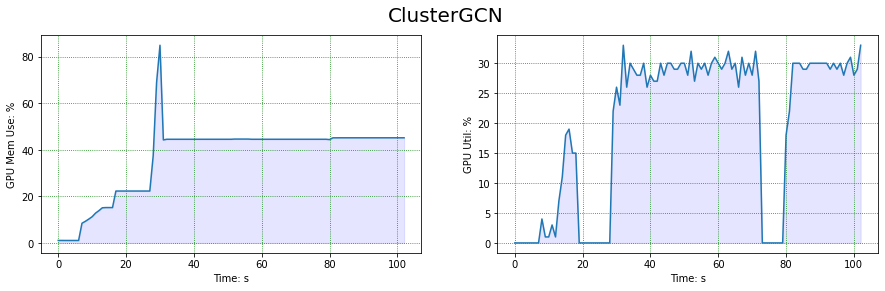

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
x = range(0,len(group_gpu_mem_use),1)
plt.plot(x,np.true_divide( np.array(group_gpu_mem_use) - start_gpu_mem_use ,total_gpu_mem)*100)
plt.fill_between(x, np.true_divide(np.array(group_gpu_mem_use) - start_gpu_mem_use ,total_gpu_mem)*100, 0, color='blue', alpha=.1)
plt.xlabel("Time: s")
plt.ylabel("GPU Mem Use: %")
plt.grid(linestyle=":", color="green")
plt.subplot(1,2,2)
x = range(0,len(group_gpu_util),1)
plt.plot(x,np.array(group_gpu_util)-start_gpu_util)
plt.fill_between(x, np.array(group_gpu_util)-start_gpu_util, 0, color='blue', alpha=.1)
plt.xlabel("Time: s")
plt.ylabel("GPU Util: %")
plt.grid(linestyle=":", color="green")
plt.suptitle("ClusterGCN",fontsize=20)
plt.savefig("./figure/BigClusterOneEpoch.png")
plt.show()